# Roof Segmentation using SAMv2

## Install Packages

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2
%cd /content/segment-anything-2
!pip install -q -e .

In [ ]:
!wget -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
!wget -O sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
!wget -O sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"
!wget -O sam2_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"

In [ ]:
# Standard library imports
import os
import json
import random
from glob import glob
from dataclasses import dataclass

# Third-party library imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch

# Custom module imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

## Image Masking

In [ ]:
@dataclass
class ProjectInfo():
  author: str
  latitude: float
  longitude: float
  size : float

class IECOProject():
  def __init__(self, project_dir):
    self.project_dir = project_dir

    self.planes = self.read_planes(project_dir)
    self.point_cloud = self.read_point_cloud(project_dir)
    self.image = self.read_image(project_dir)
    self.range = (self.point_cloud.max(axis=0) - self.point_cloud.min(axis=0))[0]
    self.info = self.read_info(project_dir)

  def read_info(self, project_dir):
    with open(os.path.join(project_dir, 'info.json')) as f:
      info = json.load(f)
    return ProjectInfo(**info)

  def read_planes(self, project_dir):
    with open(os.path.join(project_dir, 'planes.json')) as f:
      return json.load(f)

  def read_point_cloud(self, project_dir):
    with open(os.path.join(project_dir, 'dsm.json')) as f:
      return np.array(json.load(f))

  def read_image(self, project_dir):
    image = cv2.imread(os.path.join(project_dir, 'google.jpg'))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

  def draw_planes(self):
    image = np.zeros((1280, 1280, 3), dtype=np.uint8)
    color = (0, 255, 0)  # Green
    scale = 1280/self.info.size
    shift = 1280//2
    perimeters = [annotation['perimeter'] for annotation in self.planes]

    # Iterate trough annotated perimeters
    for perimeter in perimeters:
      perimeter = [ ( int(scale * row['x'] + shift), int(scale * -row['y'] + shift) )
          for row in perimeter
      ]

      # Draw a single perimeter lines
      for i in range(len(perimeter)):
        start_point = perimeter[i]
        end_point = perimeter[(i + 1) % len(perimeter)]
        cv2.line(image, start_point, end_point, color, 2)

    return image

  def overlay_perimeters(self):
    plt.imshow(self.image)
    plt.imshow(self.draw_planes(),alpha=0.5)

  def generate_mask(self):
    # Initialize a binary mask with dimensions 1280x1280, with a single channel
    mask = np.zeros((1280, 1280), dtype=np.uint8)
    scale = 1280 / self.info.size
    shift = 1280 // 2
    perimeters = [annotation['perimeter'] for annotation in self.planes]

    # Iterate through each plane and draw it on the binary mask
    for index, perimeter in enumerate(perimeters):
        points = [
            (int(scale * row['x'] + shift), int(scale * -row['y'] + shift))
            for row in perimeter
        ]
        # Fill each plane area with different labels
        cv2.fillPoly(mask, [np.array(points, dtype=np.int32)], index+1)
        # index should be 0 for background, 1..2..3.. for each plane

    # Save the binary mask as an image file
    output_path = os.path.join(self.project_dir, 'mask.png')
    cv2.imwrite(output_path, mask)

class IECODataset():
  def __init__(self, root_dir):
    self.root_dir = root_dir
    project_paths = glob(os.path.join(root_dir, '*'))

    projects = []
    for path in tqdm(project_paths):
      try:
        projects.append(IECOProject(path))
      except:
        print(f'Failed to recognize project {path}')
    self.projects = projects

  def __len__(self):
    return len(self.projects)

  def __getitem__(self, idx):
    return self.projects[idx]

In [ ]:
!unzip dataset.zip -d dataset # upload cleaned dataset

In [ ]:
dataset = IECODataset('dataset/') # load all assets
for data in tqdm(dataset, desc='generating masks'):
  data.generate_mask() # saves mask to each subdir

generating masks: 100%|██████████| 109/109 [00:00<00:00, 144.88it/s]


## Data Preparation
- resize to 1024
- mark keypoint for each plane

In [ ]:
dataset = []

for subdir in os.listdir('dataset'):
    subdir_path = os.path.join('dataset', subdir)
    image_path = os.path.join(subdir_path, 'google.jpg')
    mask_path = os.path.join(subdir_path, 'mask.png')
    dataset.append({'image': image_path, 'annotation': mask_path})


train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

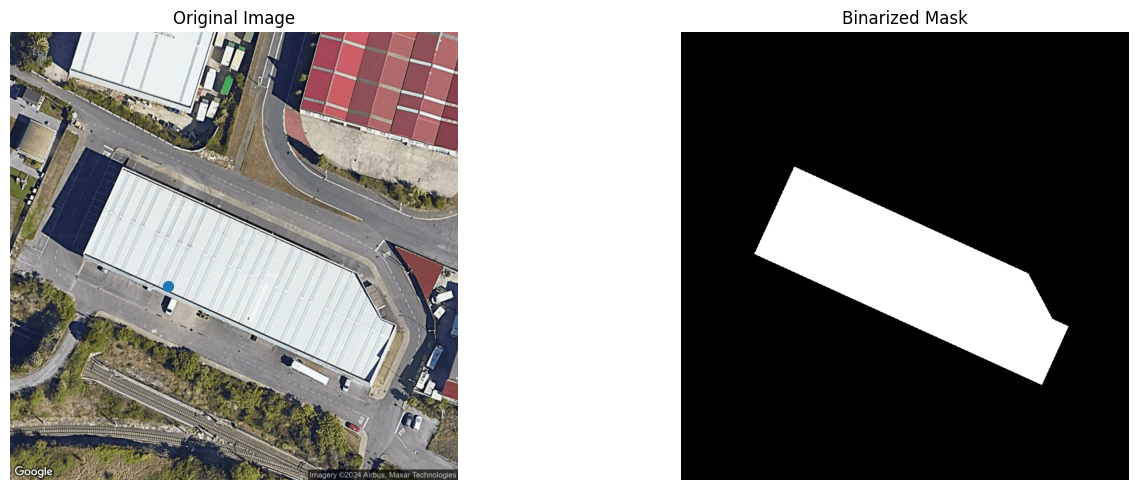

In [ ]:
def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    # Get full paths
    img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])  # Scaling factor
    img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []
    masks = []

    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        coords = np.argwhere(mask > 0)
        yx = np.array(coords[np.random.randint(len(coords))])

        points.append([yx[1], yx[0]])
        masks.append(mask)
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(img)
        plt.axis('off')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=50, label=f'Point {i+1}')  # Corrected to plot y, x order

        # Mask with Points in Different Colors
        plt.subplot(1, 2, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    masks = np.array(masks)
    points = np.expand_dims(np.array(points), axis=1)
    labels = np.ones((len(masks), 1))

    return img, masks, points, labels

# Visualize the data
img, masks, points, labels = read_batch(train_data, visualize_data=True)

In [ ]:
img.shape, masks.shape, points.shape, labels.shape

((1024, 1024, 3), (1, 1024, 1024), (1, 1, 2), (1, 1))

## Fine Tuning

In [ ]:
sam2_checkpoint = "sam2_hiera_small.pt" # ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_s.yaml" # ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Train image encoder.
predictor.model.image_encoder.train(True)

# Configure optimizer.
optimizer = torch.optim.AdamW(params=predictor.model.parameters(), lr=0.0001, weight_decay=1e-4)

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 1000

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2)
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

In [ ]:
for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast(): # cast input to mix precision
       image, masks, points, labels = read_batch(train_data, visualize_data=False) # reads a single image for every step
       if masks.shape[0] == 0: continue # ignore empty batches

       predictor.set_image(image) # image encoder
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(points, labels, box=None, mask_logits=None, normalize_coords=True)
       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       ) # prompt encoder

       # mask decoder, produce mask, and resize back
       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       # calculate cross entropy loss
       gt_mask = torch.tensor(masks.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

       # calculate IOU score
       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.05

       # Apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # Clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       # Update scheduler
       scheduler.step()

       if step % 500 == 0:
           FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
           torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

       if step == 1:
           mean_iou = 0

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Step 100:	 Accuracy (IoU) =  0.2789039420989906
Step 200:	 Accuracy (IoU) =  0.37150814618258904
Step 300:	 Accuracy (IoU) =  0.47217037369806397
Step 400:	 Accuracy (IoU) =  0.47366305041822493
Step 500:	 Accuracy (IoU) =  0.5012269345972015
Step 600:	 Accuracy (IoU) =  0.4818731054459701
Step 700:	 Accuracy (IoU) =  0.4856425566801069
Step 800:	 Accuracy (IoU) =  0.5747913698335789
Step 900:	 Accuracy (IoU) =  0.5778648551049786
Step 1000:	 Accuracy (IoU) =  0.5712439083711894


## Inference

In [ ]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

# human-based keypoint annotation
# def get_points(input_mask):
#     points = []
#     inds = np.unique(input_mask)[1:]
#     for ind in inds:
#         mask = (input_mask == ind).astype(np.uint8)  # Create binary mask for each unique index
#         coords = np.argwhere(mask > 0)
#         yx = np.array(coords[np.random.randint(len(coords))])
#         points.append([yx[1], yx[0]])

#     points = np.expand_dims(np.array(points), axis=1)
#     return points

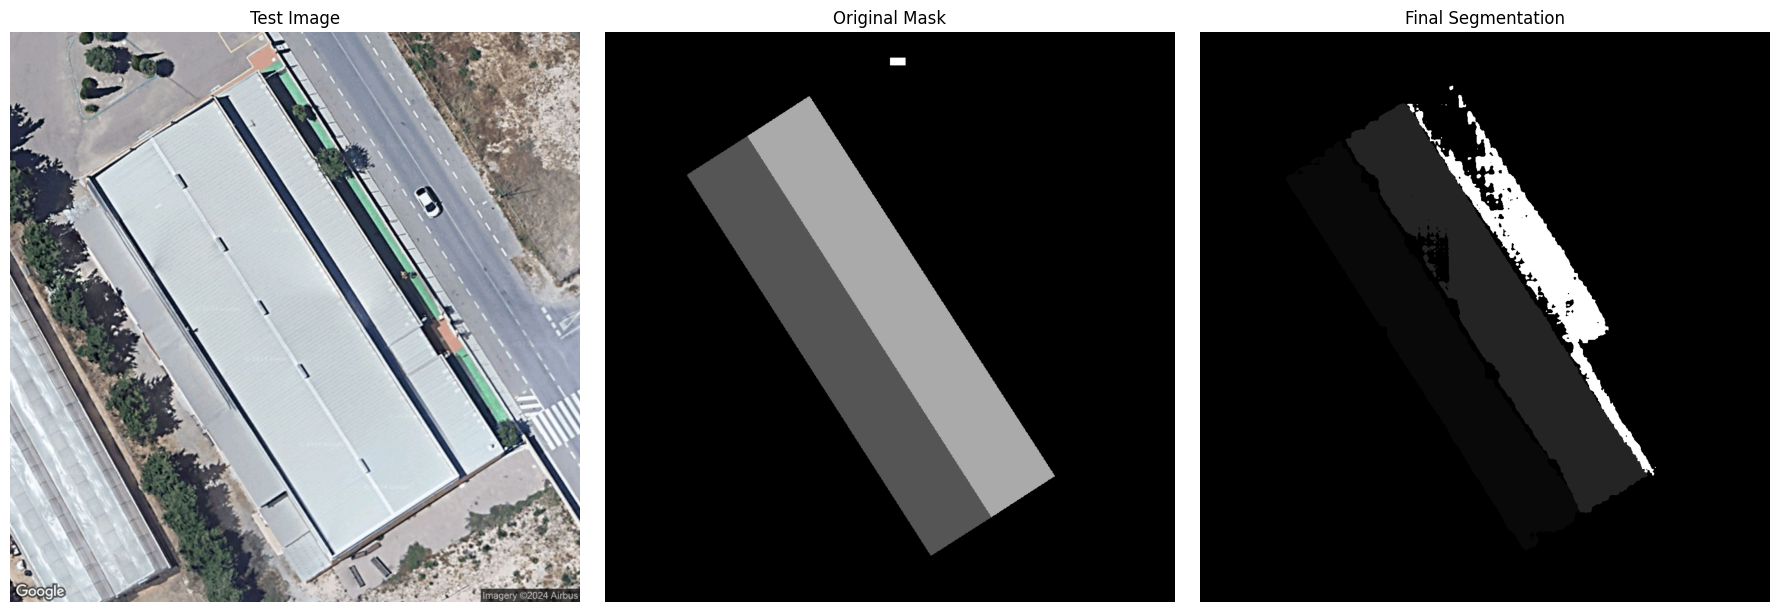

In [ ]:
# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

# Load the selected image and mask
input_image, input_mask = read_image(image_path, mask_path)
points = get_points(input_mask, 30)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_1000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(input_image)
   masks, scores, logits = predictor.predict(
       point_coords=points,
       point_labels=np.ones((len(points), 1))
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(input_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()